1. CLEAN THE DATASET

In [24]:
import pandas as pd
from unidecode import unidecode
import re

# Load your dataset (replace 'your_dataset.csv' with your actual dataset file)
fifa21_df = pd.read_csv('fifa21v2.csv', low_memory=False)


# Use the drop method to delete the specified column
fifa21_df.drop(columns=['photoUrl', 'playerUrl'], inplace=True)

column_names = fifa21_df.columns

# Rename Columns in Dataset
fifa21_df = fifa21_df.rename(columns={'LongName': 'FullName', 'Height': 'Height(ft)', 'Weight': 'Weight(lbs)', '↓OVA': 'OVA'})


# 1. Function to fix text encoding issues and normalize to ASCII
def fix_encoding(text):
    if isinstance(text, str):
        return unidecode(text)
    return text

# Apply the fix_encoding function to all columns
for column in fifa21_df.columns:
    fifa21_df[column] = fifa21_df[column].apply(fix_encoding)

# 2. Define a function to clean mixed text values in specific columns
def clean_mixed_text(value):
    if isinstance(value, str):
        # Remove characters that are not letters, digits, spaces, or common punctuation
        cleaned_value = re.sub(r'[^A-Za-z0-9\s.,!?\'"\-\(\)\[\]{}:;]', '', value)
        # Remove "EUR" and format values properly (e.g., "67M" instead of "67 M EUR")
        cleaned_value = re.sub(r'EUR', '', cleaned_value).strip()
        # Add a space before 'M' if 'M' is not present
        if not cleaned_value.endswith('M'):
            cleaned_value += 'M'
        return cleaned_value
    return value

# 2.1 Assuming 'Club' is the column with club names
fifa21_df['Club'] = fifa21_df['Club'].str.lstrip('\n')

# 2.2 Assuming 'Contract' is the column with contract years
fifa21_df['Contract'] = fifa21_df['Contract'].str.replace('~', '-')


# 2. Change Column formats and type

# Specify the columns to format
columns_to_format = ["Value", "Wage", "Release Clause"]

# Apply the clean_mixed_text function to format and clean specified columns
for column_name in columns_to_format:
    fifa21_df[column_name] = fifa21_df[column_name].apply(clean_mixed_text)

# Specify the columns to update
columns_to_update = ["Value", "Wage", "Release Clause"]

# Loop through the columns to update
for column_name in columns_to_update:
    # Extract the numerical part from the original column and store it as a new "numeric" column
    fifa21_df[f'{column_name}_numeric'] = fifa21_df[column_name].str.extract(r'(\d+\.\d+|\d+)').astype(float)
    fifa21_df[f'{column_name}_numeric'] = fifa21_df[f'{column_name}_numeric'] * 1000000

    # Update the original column with values from the "numeric" column
    fifa21_df[column_name] = fifa21_df[f'{column_name}_numeric'].astype(int)

# Drop the "numeric" columns if you no longer need them
fifa21_df.drop(columns=[f'{column_name}_numeric' for column_name in columns_to_update], inplace=True)



# 3. Define a function to convert height to centimeters
# Define a function to convert height(ft) to feet
def convert_height(height_ft):
    if 'ft' in height_ft:
        feet = float(height_ft.replace('ft', '').strip())
        return feet  # Return height in feet
    return height_ft  # Return as is if not in the 'ft' format

# Apply the conversion function to the "Height(ft)" column
fifa21_df['Height(ft)'] = fifa21_df['Height(ft)'].apply(convert_height)

# Define a function to convert pounds (lbs) to kilograms (kg)
def convert_weight(weight_lbs):
    if 'kg' in weight_lbs:
        weight_kg = int(weight_lbs.replace('kg', '').strip())
        # Convert kg to lbs (1 kg = 2.20462 lbs)
        lbs = weight_kg * 2.20462
        return f"{lbs:.2f} lbs"
    return weight_lbs  # Return as is if not in kg format

# Apply the conversion function to the "Weight" column
fifa21_df['Weight(lbs)'] = fifa21_df['Weight(lbs)'].apply(convert_weight)

# Specify the path for the new CSV file (replace 'output_dataset.csv' with your desired file name)
output_csv_path = 'Final Fifa21.csv'

# Save the updated DataFrame to a new CSV file
fifa21_df.to_csv(output_csv_path, index=False)

print(f"New CSV file saved as '{output_csv_path}'")
fifa21_df.info()


New CSV file saved as 'Final Fifa21.csv'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18979 entries, 0 to 18978
Data columns (total 75 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                18979 non-null  int64 
 1   Name              18979 non-null  object
 2   FullName          18979 non-null  object
 3   Nationality       18979 non-null  object
 4   Age               18979 non-null  int64 
 5   OVA               18979 non-null  int64 
 6   POT               18979 non-null  int64 
 7   Club              18979 non-null  object
 8   Contract          18979 non-null  object
 9   Positions         18979 non-null  object
 10  Height(ft)        18979 non-null  object
 11  Weight(lbs)       18979 non-null  object
 12  Preferred Foot    18979 non-null  object
 13  BOV               18979 non-null  int64 
 14  Best Position     18979 non-null  object
 15  Joined            18979 non-null  object
 16  Loan Date End    

2. Based on the 'Joined' column, check which players have been playing at a club for more than 10 years!

In [25]:
import pandas as pd
from datetime import datetime

# Load your dataset (replace 'your_dataset.csv' with your actual dataset file)
fifa21_df = pd.read_csv('Final Fifa21.csv', low_memory=False)

# Convert the 'Joined' column to datetime format
fifa21_df['Joined'] = pd.to_datetime(fifa21_df['Joined'], errors='coerce')

# Calculate the number of years each player has been at the club
current_date = datetime.now()
fifa21_df['Years_at_Club'] = (current_date - fifa21_df['Joined']).dt.days / 365

# Filter players who have been at the club for more than 10 years
players_over_10_years = fifa21_df[fifa21_df['Years_at_Club'] > 10]

# Print the players who meet the criteria
print(players_over_10_years[['Name', 'Joined', 'Years_at_Club']])


                Name     Joined  Years_at_Club
0           L. Messi 2004-07-01      19.246575
12          Casemiro 2013-07-11      10.213699
14          M. Neuer 2011-07-01      12.243836
15        K. Benzema 2009-07-09      14.221918
16      Sergio Ramos 2005-08-01      18.161644
...              ...        ...            ...
17207     Yao Hanlin 2010-01-01      13.739726
17247   O. Al Sunain 2013-07-01      10.241096
17276    Chang Feiya 2013-01-01      10.736986
17811     Sun Shoubo 2013-02-15      10.613699
18430  B. Al Bahrani 2013-07-01      10.241096

[677 rows x 3 columns]


3. Find Undervalued Players

Top 10 Most Underpaid Players:
Name: M. Lugo, Value: 975000000, Wage: 1000000
Name: Y. Takaoka, Value: 975000000, Wage: 1000000
Name: D. Khalid, Value: 975000000, Wage: 1000000
Name: G. Tomasiewicz, Value: 975000000, Wage: 1000000
Name: D. Tijanic, Value: 975000000, Wage: 1000000
Name: M. Krauss, Value: 975000000, Wage: 1000000
Name: Andre Mesquita, Value: 975000000, Wage: 1000000
Name: I. Kebe, Value: 975000000, Wage: 1000000
Name: Oscar Clemente, Value: 975000000, Wage: 1000000
Name: R. Quirynen, Value: 975000000, Wage: 1000000


<Figure size 1500x1000 with 0 Axes>

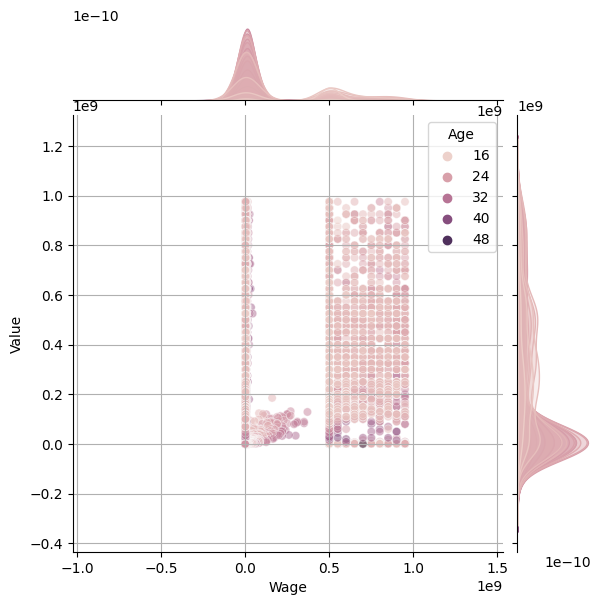

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset (replace 'your_dataset.csv' with your actual dataset file)
fifa21_df = pd.read_csv('Final Fifa21.csv', low_memory=False)

# Create a scatter plot using Seaborn
plt.figure(figsize=(15, 10))
sns.jointplot(x='Wage', y='Value', data=fifa21_df, alpha=0.5, hue='Age')
plt.xlabel('Wage')
plt.ylabel('Value')
plt.grid(True)

# Calculate a metric for underpaid players (e.g., Value-to-Wage ratio)
fifa21_df['Value_to_Wage_Ratio'] = fifa21_df['Value'] / fifa21_df['Wage']

# Find the top 10 most underpaid players based on the Value-to-Wage ratio
top_underpaid_players = fifa21_df.nlargest(10, 'Value_to_Wage_Ratio')

# Print the list of top 10 most underpaid players
print("Top 10 Most Underpaid Players:")
for index, row in top_underpaid_players[['Name', 'Value', 'Wage']].iterrows():
    print(f"Name: {row['Name']}, Value: {row['Value']}, Wage: {row['Wage']}")

# Show the scatter plot
plt.show()


3. Oldest and Youngest Players and their information

Oldest Player:
ID                      254704
Name                  K. Miura
FullName       Kazuyoshi Miura
Nationality              Japan
Age                         53
                    ...       
PAS                         55
DRI                         60
DEF                         19
PHY                         47
Hits                       125
Name: 16109, Length: 75, dtype: object

Youngest Player:
ID                   251570
Name              R. Cherki
FullName       Rayan Cherki
Nationality          France
Age                      16
                   ...     
PAS                      62
DRI                      74
DEF                      20
PHY                      58
Hits                     1K
Name: 8116, Length: 75, dtype: object


<Figure size 1500x1000 with 0 Axes>

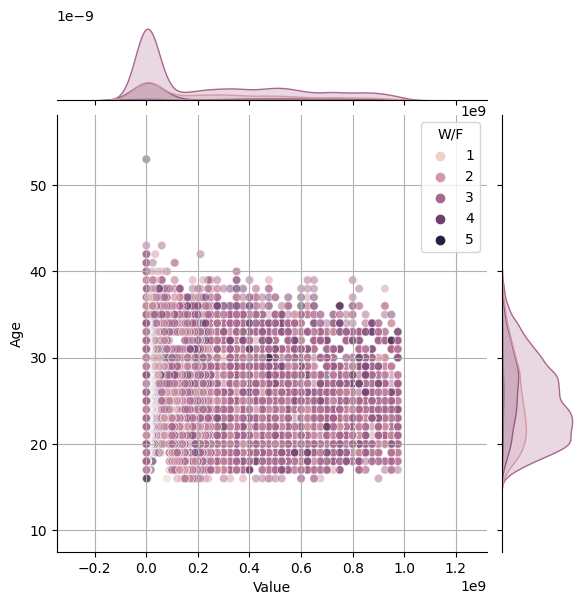

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset (replace 'your_dataset.csv' with your actual dataset file)
fifa21_df = pd.read_csv('Final Fifa21.csv', low_memory=False)

# Create a scatter plot using Seaborn
plt.figure(figsize=(15, 10))
sns.jointplot(x='Value', y='Age', data=fifa21_df, alpha=0.5, hue="W/F")
plt.xlabel('Value')
plt.ylabel('Age')
plt.grid(True)

# Convert the "Age" column to numeric (in case it's not already)
fifa21_df['Age'] = pd.to_numeric(fifa21_df['Age'], errors='coerce')

# Find the oldest and youngest players
oldest_player = fifa21_df.loc[fifa21_df['Age'].idxmax()]
youngest_player = fifa21_df.loc[fifa21_df['Age'].idxmin()]

# Print the information of the oldest player
print("Oldest Player:")
print(oldest_player)

# Print the information of the youngest player
print("\nYoungest Player:")
print(youngest_player)



4. Goal Keeper STATS

             Movement  Reactions   Balance     Power  Shot Power  Mentality  \
Movement     1.000000   0.675764  0.637230  0.737210    0.505933   0.593681   
Reactions    0.675764   1.000000  0.200374  0.648893    0.651581   0.571390   
Balance      0.637230   0.200374  1.000000  0.393056    0.140351   0.291505   
Power        0.737210   0.648893  0.393056  1.000000    0.630243   0.639892   
Shot Power   0.505933   0.651581  0.140351  0.630243    1.000000   0.519411   
Mentality    0.593681   0.571390  0.291505  0.639892    0.519411   1.000000   
Aggression   0.294110   0.301278  0.091973  0.368375    0.251476   0.601008   
Composure    0.498916   0.540615  0.184638  0.508782    0.472601   0.547464   
Goalkeeping  0.589423   0.806193  0.136188  0.678612    0.863978   0.555895   
GK Diving    0.577614   0.777504  0.138639  0.637330    0.746407   0.502182   
GK Handling  0.520020   0.744312  0.099885  0.605413    0.764539   0.506723   

             Aggression  Composure  Goalkeeping  GK

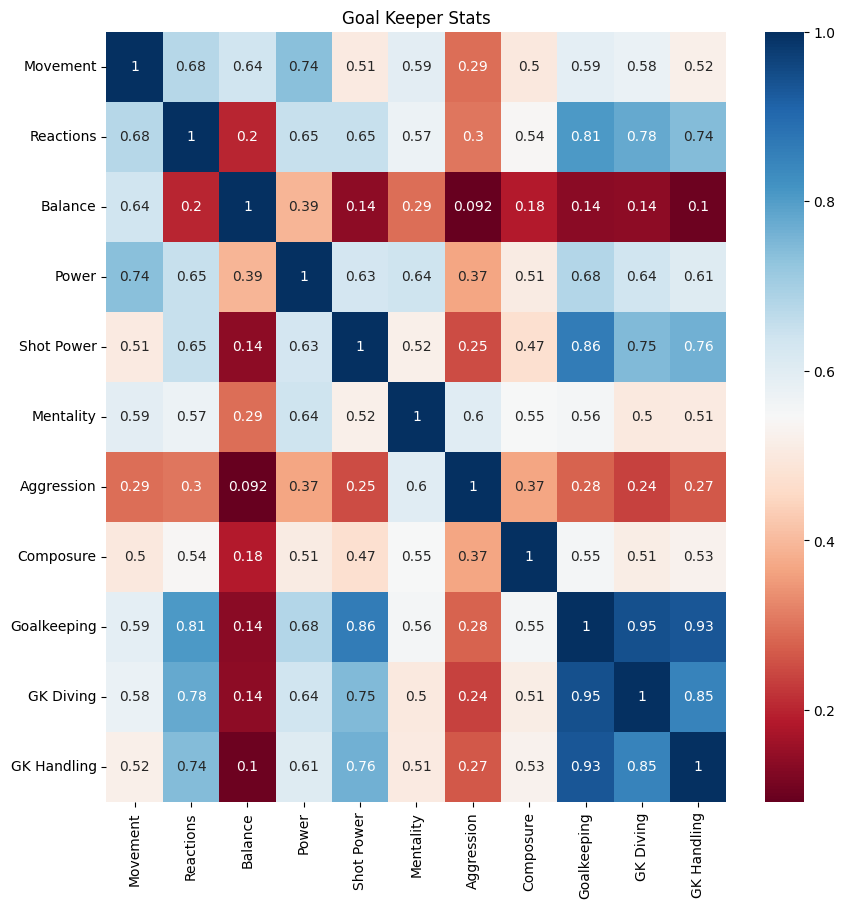

In [37]:
import pandas as pd

# Load your dataset
fifa21_df = pd.read_csv('Final Fifa21.csv', low_memory=False)

fifa21_gk = fifa21_df[fifa21_df['Best Position']=='GK']

fifa21_gkheat = fifa21_gk[[#'ID', 'Name', 'FullName', 'Nationality', 'Age', 'OVA', 'POT', 'Club',
      # 'Contract', 'Positions', 'Height(ft)', 'Weight(lbs)', 'Preferred Foot',
      # 'BOV', 'Best Position', 'Joined', 'Loan Date End', 'Value', 'Wage',
      # 'Release Clause', 'Attacking', 'Crossing', 'Finishing',
      # 'Heading Accuracy', 'Short Passing', 'Volleys', 'Skill', 'Dribbling',
      # 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control',
        'Movement',
      # 'Acceleration', 'Sprint Speed', 'Agility',
        'Reactions', 'Balance',
        'Power', 'Shot Power', 
      # 'Jumping', 'Stamina', 'Strength', 'Long Shots',
        'Mentality', 'Aggression',
      # 'Interceptions', 'Positioning', 'Vision',
      # 'Penalties',
        'Composure',
      # 'Defending', 'Marking', 'Standing Tackle',
      # 'Sliding Tackle',
        'Goalkeeping', 'GK Diving', 'GK Handling',
      # 'GK Kicking', 'GK Positioning', 'GK Reflexes',
      # 'Total Stats',
      # 'Base Stats', 'W/F', 'SM', 'A/W', 'D/W', 'IR', 'PAC', 'SHO', 'PAS',
      # 'DRI', 'DEF', 'PHY', 'Hits'
      ]].dropna().corr()


plt.figure(figsize = (10,10))
plt.title('Goal Keeper Stats')
sns.set_palette("RdBu")
sns.heatmap(fifa21_gkheat,annot=True, cbar = True, cmap = 'RdBu')

print(fifa21_gkheat)
